# Assignment 2 - Image Captioning

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of image captioning : -from loading and inspecting the dataset; -to implementing, training and evaluating an Encoder-Decoder + Attention based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- From the provided Flickr8k dataset, split it into train, val and test sets;
- Use the train set to train an Image Captioning model, the val set for validation of the model and hyper-parameters, and the test set to evaluate the final trained model;
- For this assignment, we will give importance to the performance of your model, meaning that, we will evaluate if your model is overfitted or underfitted. For that, please include visualizations (print and plot) loss values for the split sets, as well as the metric results;
- For the metric, while we do not require high performance, we still expect better than random guessing results;
- For the comparison, you are free to choose any pre-trained model;
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is November 29th 11:59 PM** (strict, no late submission);
- Feel free to add more code cells as needed. But don't put code into external Python files;
- Please add your name, **Neptun ID**, and task details below.

**Name: Kocsis Barnabás**  
**Neptun ID: IT8NLQ**

## Task description

Your task is to train your own custom image captioning model and compare its performance with an existing (pre-trained) model. For that, first you need to load the provided Flickr8k dataset, split into train, val and test sets. Then, create your own architecture, which should follow an Encoder-Decoder + Attention sturcture. You can use pre-trained backbones (i.e. ResNet) for the encoder, but they have to be fine-tuned. We expect you to use an Attention layer, in order to visualize how the network learned (see more details on section 2 of the notebook).
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs. Please use BLEU score as the metric**. We expect you to **show visualizations (prints and plots)** of the **metrics, losses, and predictions**. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your architecture.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [ ]:
from PIL import Image
from collections import Counter
from google.colab import files
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader, Subset
from torchvision import transforms
from tqdm import tqdm
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms


# 1. DATASET
For this assignment you will be using the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset, which contains captions/descriptions of different images.

### 1.1. Download dataset
The best way to download this dataset is through Kaggle.
First create a token, download it and upload it here. Follow these steps: https://www.kaggle.com/discussions/general/74235

In [1]:
!pip install -q kaggle

^C



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Barnabas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
from google.colab import files
files.upload()

In [7]:
!mkdir %HOMEPATH%\.kaggle


A subdirectory or file \Users\GamerBarny\.kaggle already exists.


In [8]:
!copy kaggle.json "%HOMEPATH%\.kaggle\"

        1 file(s) copied.


In [9]:

!chmod 600 ~/.kaggle/kaggle.json

'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0




  0%|          | 0.00/1.04G [00:00<?, ?B/s]
  0%|          | 1.00M/1.04G [00:00<13:01, 1.42MB/s]
  0%|          | 2.00M/1.04G [00:00<06:37, 2.79MB/s]
  0%|          | 5.00M/1.04G [00:00<02:25, 7.64MB/s]
  1%|          | 9.00M/1.04G [00:01<01:17, 14.2MB/s]
  1%|          | 13.0M/1.04G [00:01<00:55, 19.7MB/s]
  2%|▏         | 17.0M/1.04G [00:01<00:44, 24.6MB/s]
  2%|▏         | 21.0M/1.04G [00:01<00:38, 28.4MB/s]
  2%|▏         | 25.0M/1.04G [00:01<00:35, 30.9MB/s]
  3%|▎         | 29.0M/1.04G [00:01<00:33, 32.8MB/s]
  3%|▎         | 33.0M/1.04G [00:01<00:31, 34.3MB/s]
  3%|▎         | 37.0M/1.04G [00:02<00:47, 22.4MB/s]
  4%|▍         | 41.0M/1.04G [00:02<00:41, 26.0MB/s]
  4%|▍         | 45.0M/1.04G [00:02<00:36, 29.0MB/s]
  5%|▍         | 49.0M/1.04G [00:02<00:34, 31.0MB/s]
  5%|▍         | 53.0M/1.04G [00:02<00:31, 33.2MB/s]
  5%|▌         | 57.0M/1.04G [00:02<00:30, 34.5MB/s]
  6%|▌         | 61.0M/1.04G [00:02<00:29, 35.9MB/s]
  6%|▌         | 65.0M/1.04G [00:02<00:28, 36.9MB/s]
 

In [11]:
!unzip flickr8k.zip -d flickr8k

'unzip' is not recognized as an internal or external command,
operable program or batch file.


### 1.2. Load dataset
In order to load the dataset, you need to create a pytorch Dataset class.
The class should return images and captions. Remember that the captions should be returned as tokens. Do not forget to include the SOS:start of sentence, EOS:end of sentence and UNK:unknown tokens. You may want to build a vocabulary class in order to save all the words in your dataset, because your model can only predict words in your vocabulary. You do not have to save every word in your vocabulary, it is common practice to save only those words that appear multiple times in your whole dataset. For example, save only words that appear at least 5 times in your whole dataset.

In [ ]:
from collections import Counter
import torch
from torch.utils.data import Dataset
import os
import pandas as pd
from PIL import Image

class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        return text.lower().split()

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = len(self.itos)

        for sentence in sentence_list:
            frequencies.update(self.tokenizer(sentence))

        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [
            self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text
        ]

class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.df["caption"].tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        caption = self.df.iloc[idx, 1]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        caption_vec = [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(caption_vec)


Example output from dataset class

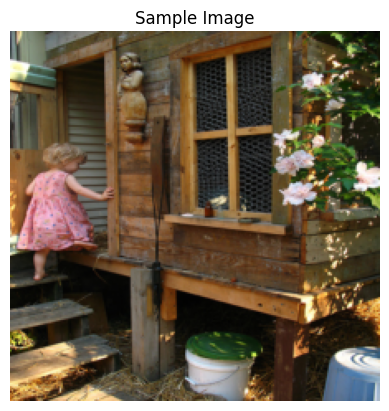

Tokenized Caption: tensor([ 1,  4,  5,  6,  4,  7,  8,  9, 10, 11,  4, 12, 13, 14,  6, 15,  3, 16,
        17,  2])
Decoded Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FlickrDataset(
    root_dir="Images/",
    captions_file="captions.txt",
    transform=transform,
    freq_threshold=5
)

def show_image(image, title="Image"):
    
    if isinstance(image, torch.Tensor):
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image = image * std[:, None, None] + mean[:, None, None]

        image = image.permute(1, 2, 0).numpy()

    plt.imshow(np.clip(image, 0, 1))
    plt.title(title)
    plt.axis('off')
    plt.show()

img, caps = dataset[0]
show_image(img, "Sample Image")
print("Tokenized Caption:", caps)
print("Decoded Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])


Split your dataset into train, val and test sets

Create a dataloader, in order to load the examples in batches. Remember that, a batch has different examples, and each example (caption) may have different sizes. Therefore, consider padding techniques for the captions. For the image, use transforms in the previous step, to ensure same format and size. 

C:\Users\GamerBarny\AppData\Local\Temp\ipykernel_8984\579635606.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  captions = [torch.tensor(item[1], dtype=torch.long) for item in batch]


Batch of Images Shape: torch.Size([32, 3, 224, 224])
Batch of Captions Shape: torch.Size([32, 19])


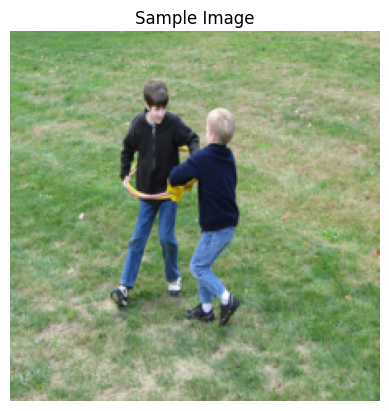

First Caption Tokens: tensor([   1,   47,  428,    6, 1045,  264,   36, 2675, 2037,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0])
Decoded Caption: ['<SOS>', 'two', 'boys', 'in', 'denim', 'play', 'with', 'hula', 'hoops', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [ ]:
from torch.utils.data import DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms
from sklearn.model_selection import train_test_split


def split_dataset(dataset, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2, seed=42):
    assert train_ratio + val_ratio + test_ratio == 1.0,

    train_indices, temp_indices = train_test_split(
        range(len(dataset)),
        test_size=(1 - train_ratio),
        random_state=seed
    )

    val_size = val_ratio / (val_ratio + test_ratio)
    val_indices, test_indices = train_test_split(
        temp_indices,
        test_size=(1 - val_size),
        random_state=seed
    )

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

class CollateFn:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images = [item[0] for item in batch]
        captions = [torch.tensor(item[1], dtype=torch.long) for item in batch]

        images_stacked = torch.stack(images)
        captions_padded = pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)

        return images_stacked, captions_padded

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FlickrDataset(
    root_dir="Images/",
    captions_file="captions.txt",
    transform=image_transforms,
    freq_threshold=5
)

train_dataset, val_dataset, test_dataset = split_dataset(dataset, seed=42)

pad_idx = dataset.vocab.stoi["<PAD>"]

batch_size = 32
collate_fn = CollateFn(pad_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

def show_batch(loader):
    images, captions = next(iter(loader))
    print("Batch of Images Shape:", images.shape)
    print("Batch of Captions Shape:", captions.shape)

    img = images[0]
    img = img * torch.tensor([0.229, 0.224, 0.225])[:, None, None] + torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(np.clip(img, 0, 1))
    plt.axis("off")
    plt.title("Sample Image")
    plt.show()

    print("First Caption Tokens:", captions[0])
    print("Decoded Caption:", [dataset.vocab.itos[idx.item()] for idx in captions[0]])

show_batch(train_loader)


C:\Users\GamerBarny\AppData\Local\Temp\ipykernel_8984\579635606.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  captions = [torch.tensor(item[1], dtype=torch.long) for item in batch]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.2739873].


Image 1:


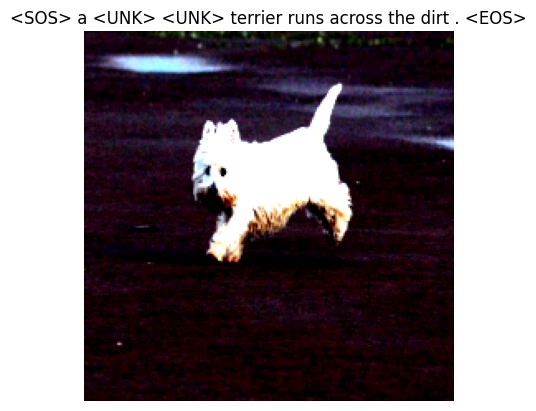

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.343704].


Image 2:


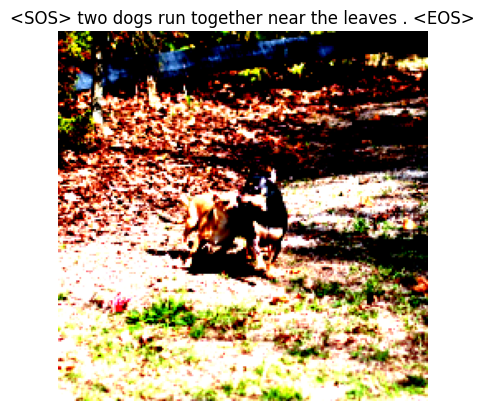

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.64].


Image 3:


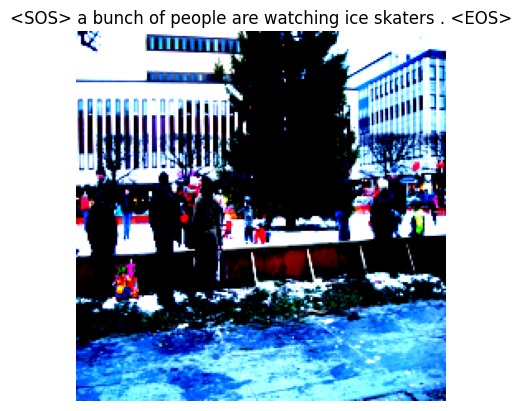

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


Image 4:


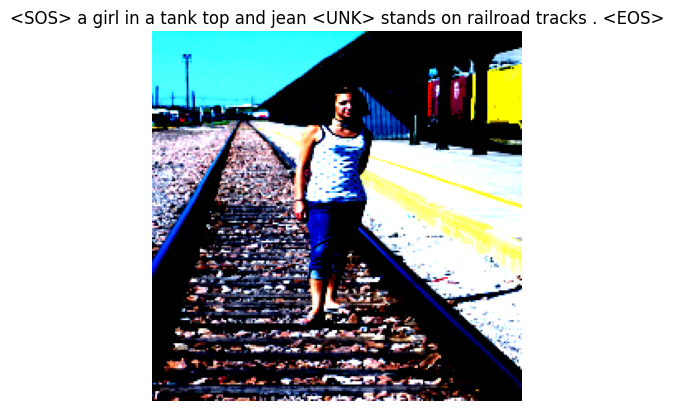

In [ ]:
def show_image_with_caption(img, caption, vocab, pad_idx):
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()

    sentence = [vocab.itos[token] for token in caption if token != pad_idx]

    plt.imshow(img)
    plt.title(" ".join(sentence))
    plt.axis("off")
    plt.show()

batch_size = 4

example_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

for images, captions in example_loader:
    for i in range(batch_size):
        print(f"Image {i + 1}:")
        show_image_with_caption(
            images[i], captions[i].tolist(), dataset.vocab, pad_idx
        )
    break


#2. MODEL
For this assignment, you are required to create your own custom image captioning model and compare its performance with an existing pre-trained model.

In [ ]:
#Make sure to use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 2.1. Custom Image Captioning model

Create an Encoder-Attention-Decoder architecture with the following details:
- the encoder should process the images, thus you can create a Convolutional based architecture or use already pre-trained models like ResNet. However, you must fine-tune the pretrained model. The encoder is responisble for extracting image features;
- the attention layer should be between the encoder and decoder. It uses the image features from the encoder in order to provide context (attention scores) to the decoder hidden layers. For simplicity use Linear layers as the attention architecture;
- the decoder should be a sequence based model (i.e. LSTM) in order to process and generate captions.

Extra:
- Extra points (counting toward the final grade) will be given to any student who implements either a Vision-based Transformer architecture or a Transformer only decoder for the decoder part.

#### Reference
Here is an example of something similar to what we want to create:
<img src="https://drive.google.com/thumbnail?id=1wdddaLit7iEyCcVy5bS505NiYzL6c-4x&sz=w1000">


In [ ]:
# Experimenting with block freezing (not final Encoder class)
class Encoder(nn.Module):
    def __init__(self, fine_tune=True):
        super(Encoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        
        self.fine_tune(fine_tune)

    def forward(self, images):
        features = self.features(images)
        return features

    def fine_tune(self, fine_tune=True):
        
        for param in self.features.parameters():
            param.requires_grad = False

        if fine_tune:
            for layer in list(self.features.children())[-3:]:
                for param in layer.parameters():
                    param.requires_grad = True

In [ ]:
# Final Encoder Class
class Encoder(nn.Module):
    def __init__(self, embed_size=None, fine_tune_blocks=None, fixed_feature_size=(14, 14), pretrained=True):
        super(Encoder, self).__init__()
        resnet = models.resnet50(pretrained=pretrained)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d(fixed_feature_size) if fixed_feature_size else None
        self.embed_size = embed_size
        self.fc = nn.Linear(resnet.fc.in_features, embed_size) if embed_size else None
        self._set_fine_tuning(fine_tune_blocks)

    def forward(self, images):
        features = self.features(images)
        if self.adaptive_pool:
            features = self.adaptive_pool(features)
        features = features.permute(0, 2, 3, 1).view(features.size(0), -1, features.size(1))
        if self.fc:
            features = self.fc(features)
        return features

    def _set_fine_tuning(self, fine_tune_blocks):
        for param in self.features.parameters():
            param.requires_grad = False
        if fine_tune_blocks == -1:
            for param in self.features.parameters():
                param.requires_grad = True
        elif fine_tune_blocks:
            for layer in list(self.features.children())[-fine_tune_blocks:]:
                for param in layer.parameters():
                    param.requires_grad = True


In [ ]:
# Fineal Attention Class
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, hidden_state):
        encoder_proj = self.encoder_att(features)
        decoder_proj = self.decoder_att(hidden_state).unsqueeze(1)
        combined = self.relu(encoder_proj + decoder_proj)
        attention_scores = self.full_att(combined).squeeze(2)
        weights = self.softmax(attention_scores)
        context = torch.sum(features * weights.unsqueeze(2), dim=1)
        return context, weights


In [ ]:
class Decoder(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, dropout=0.5):
        super(Decoder, self).__init__()
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTMCell(embed_size + encoder_dim, decoder_dim)
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.dropout = nn.Dropout(dropout)

    # def init_hidden_state(self, features):
    #     mean_features = features.mean(dim=1)
    #     h = self.init_h(mean_features)
    #     c = self.init_c(mean_features)
    #     return h, c

    def init_hidden_state(self, features):
        mean_features = features.mean(dim=1)

        h = self.init_h(mean_features) # Represents the short-term memory of the LSTM
        c = self.init_c(mean_features) # Represents the long-term memory of the LSTM
        
        print(h.shape, c.shape)
        
        return h, c

    def forward(self, features, captions):
        batch_size = features.size(0)
        seq_length = captions.size(1) - 1
        h, c = self.init_hidden_state(features)
        embeddings = self.embedding(captions[:, :-1])
        outputs = torch.zeros(batch_size, seq_length, self.fc.out_features).to(features.device)
        for t in range(seq_length):
            context, _ = self.attention(features, h)
            lstm_input = torch.cat((embeddings[:, t, :], context), dim=1)
            h, c = self.lstm(lstm_input, (h, c))
            outputs[:, t, :] = self.fc(self.dropout(h))
        return outputs


Combine the encoder - attention - decoder

In [ ]:
# First try
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder()
        
        self.decoder = Decoder(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim)

    def forward(self, images, captions):
       
        features = self.encoder(images)

        outputs = self.decoder(features, captions)

        return outputs


In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, dropout=0.5):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder(embed_size=encoder_dim, fine_tune_blocks=2, fixed_feature_size=(14, 14), pretrained=True)
        self.decoder = Decoder(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, dropout)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


### 2.2. Training custom model

### Important: we recommend saving the model during training, so that you can resume training later

In [ ]:
def save_model(model, embed_size, attention_dim, encoder_dim, decoder_dim, num_epochs, path='image_captioning.pth'):
    
    model_state = {
        'embed_size': embed_size,
        'attention_dim': attention_dim,
        'encoder_dim': encoder_dim,
        'decoder_dim': decoder_dim,
        'state_dict': model.state_dict(),
        'num_epochs': num_epochs
    }
    path = str(num_epochs) + "_" + path
    torch.save(model_state, path)
    print(f"Model saved to {path}")


Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.

#### First model

C:\Users\GamerBarny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\GamerBarny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\GamerBarny\AppData\Local\Temp\ipykernel_15208\2568639393.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Model saved to image_captioning.pth
Epoch [1/10], Train Loss: 4.6809, Val Loss: 4.0005
Model saved to image_captioning.pth
Epoch [2/10], Train Loss: 3.9241, Val Loss: 3.6766
Model saved to image_captioning.pth
Epoch [3/10], Train Loss: 3.6955, Val Loss: 3.5323
Model saved to image_captioning.pth
Epoch [4/10], Train Loss: 3.5694, Val Loss: 3.4378
Model saved to image_captioning.pth
Epoch [5/10], Train Loss: 3.4755, Val Loss: 3.3643
Model saved to image_captioning.pth
Epoch [6/10], Train Loss: 3.3989, Val Loss: 3.3038
Model saved to image_captioning.pth
Epoch [7/10], Train Loss: 3.3358, Val Loss: 3.2513
Model saved to image_captioning.pth
Epoch [8/10], Train Loss: 3.2811, Val Loss: 3.2038
Model saved to image_captioning.pth
Epoch [9/10], Train Loss: 3.2341, Val Loss: 3.1714
Model saved to image_captioning.pth
Epoch [10/10], Train Loss: 3.1939, Val Loss: 3.1431


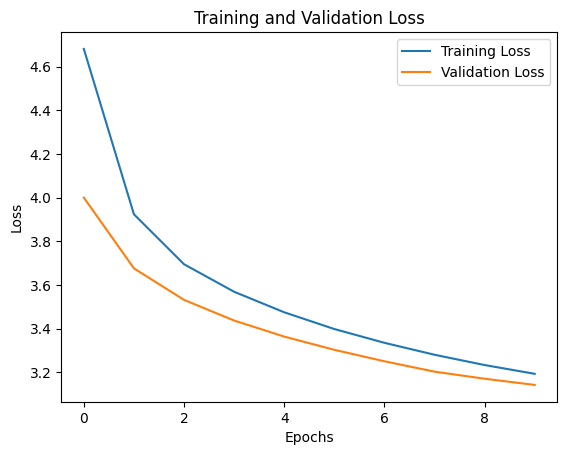

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

embed_size = 256
vocab_size = len(dataset.vocab)
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512

model = ImageCaptioningModel(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

num_epochs = 10
save_path = "image_captioning.pth"

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, captions in train_loader:
            images, captions = images.to(device), captions.to(device)
            
            outputs = model(images, captions)
            loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, captions in val_loader:
                images, captions = images.to(device), captions.to(device)
                
                outputs = model(images, captions)
                loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))
                
                val_running_loss += loss.item()

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)

        save_model(model, embed_size, attention_dim, encoder_dim, decoder_dim, epoch + 1, save_path)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    save_path
)

plot_losses(train_losses, val_losses)


#### Final model


Epoch 1/10:   0%|          | 0/885 [00:00<?, ?it/s]C:\Users\GamerBarny\AppData\Local\Temp\ipykernel_8984\579635606.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  captions = [torch.tensor(item[1], dtype=torch.long) for item in batch]
Epoch 1/10: 100%|██████████| 885/885 [14:36<00:00,  1.01it/s]


Epoch 1/10, Train Loss: 4.3783, Val Loss: 3.7670
Model saved at epoch 1.


Epoch 2/10: 100%|██████████| 885/885 [12:41<00:00,  1.16it/s]


Epoch 2/10, Train Loss: 3.6295, Val Loss: 3.4036
Model saved at epoch 2.


Epoch 3/10: 100%|██████████| 885/885 [11:58<00:00,  1.23it/s]


Epoch 3/10, Train Loss: 3.3292, Val Loss: 3.1844
Model saved at epoch 3.


Epoch 4/10: 100%|██████████| 885/885 [11:55<00:00,  1.24it/s]


Epoch 4/10, Train Loss: 3.1245, Val Loss: 3.0358
Model saved at epoch 4.


Epoch 5/10: 100%|██████████| 885/885 [12:23<00:00,  1.19it/s]


Epoch 5/10, Train Loss: 2.9679, Val Loss: 2.9238
Model saved at epoch 5.


Epoch 6/10: 100%|██████████| 885/885 [12:20<00:00,  1.19it/s]


Epoch 6/10, Train Loss: 2.8392, Val Loss: 2.8376
Model saved at epoch 6.


Epoch 7/10: 100%|██████████| 885/885 [12:52<00:00,  1.15it/s]


Epoch 7/10, Train Loss: 2.7303, Val Loss: 2.7714
Model saved at epoch 7.


Epoch 8/10: 100%|██████████| 885/885 [12:38<00:00,  1.17it/s]


Epoch 8/10, Train Loss: 2.6349, Val Loss: 2.7239
Model saved at epoch 8.


Epoch 9/10: 100%|██████████| 885/885 [12:28<00:00,  1.18it/s]


Epoch 9/10, Train Loss: 2.5487, Val Loss: 2.6851
Model saved at epoch 9.


Epoch 10/10: 100%|██████████| 885/885 [12:49<00:00,  1.15it/s]


Epoch 10/10, Train Loss: 2.4681, Val Loss: 2.6495
Model saved at epoch 10.


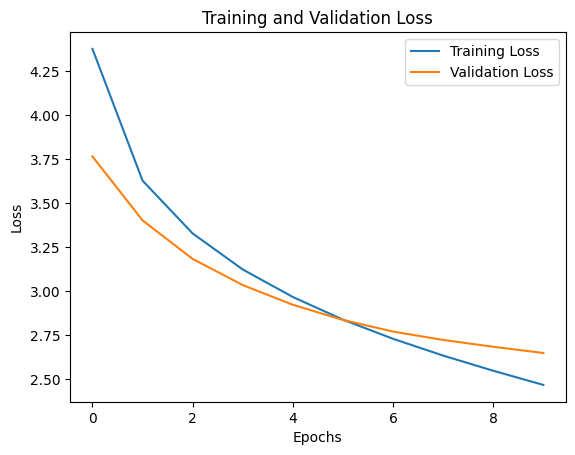

In [ ]:
import torch.optim as optim
from tqdm import tqdm

embed_size = 256
encoder_dim = 256
vocab_size = len(dataset.vocab)
attention_dim = 256
decoder_dim = 512
learning_rate = 1e-4
weight_decay = 1e-5
num_epochs = 10
save_path = "image_captioning.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ImageCaptioningModel(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


def save_model(model, epoch, save_path):
    torch.save({
        'state_dict': model.state_dict(),
        'epoch': epoch,
        'embed_size': embed_size,
        'attention_dim': attention_dim,
        'encoder_dim': encoder_dim,
        'decoder_dim': decoder_dim,
    }, save_path)
    print(f"Model saved at epoch {epoch}.")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path):
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, captions in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, captions = images.to(device), captions.to(device)
            
            outputs = model(images, captions)
            loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, captions in val_loader:
                images, captions = images.to(device), captions.to(device)
                outputs = model(images, captions)
                loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        save_model(model, epoch+1, save_path)
    
    return train_losses, val_losses

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path
)
plot_losses(train_losses, val_losses)


#### Experimantal model

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def load_model2(checkpoint_path, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, device):
    
    print(f"Loading model from {checkpoint_path}...")
    
    model = ImageCaptioningModel(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim).to(device)
    
    model.load_state_dict(torch.load(checkpoint_path))
    print("Model successfully loaded.")
    
    return model


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, latest_path='latest_model.pth', best_path='best_model.pth'):
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, captions in train_loader:
            images, captions = images.to(device), captions.to(device)
            
            outputs = model(images, captions)
            loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, captions in val_loader:
                images, captions = images.to(device), captions.to(device)
                
                outputs = model(images, captions)
                loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))
                
                val_running_loss += loss.item()

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)

        torch.save(model.state_dict(), latest_path)
        print(f"Latest checkpoint saved to {latest_path}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)
            print(f"Best checkpoint saved to {best_path}")

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses


In [ ]:
import torch.optim as optim

embed_size = 256 
vocab_size = len(dataset.vocab)
attention_dim = 256 
encoder_dim = 2048
decoder_dim = 512  


def train_with_frozen_encoder():
    print("Phase 1: Training with frozen encoder...")

    model = ImageCaptioningModel(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim)
    model.encoder.fine_tune(fine_tune=False)  # Freeze encoder
    model = model.to(device)
    
    params = list(model.decoder.parameters()) + list(model.decoder.attention.parameters())
    optimizer = optim.Adam(params, lr=1e-4, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    
    train_losses, val_losses = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=5,
        device=device,
        latest_path="latest_model_frozen_encoder.pth",
        best_path="best_model_frozen_encoder.pth"
    )

    plot_losses(train_losses, val_losses)

    return model


def fine_tune_encoder(model):
    print("Phase 2: Fine-tuning the encoder...")

    model.encoder.fine_tune(fine_tune=True)
    
    params = list(model.encoder.parameters()) + list(model.decoder.parameters()) + list(model.decoder.attention.parameters())
    optimizer = optim.Adam(params, lr=1e-5, weight_decay=1e-5) 
    
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    
    train_losses, val_losses = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=5,
        device=device,
        latest_path="latest_model_encoder.pth",
        best_path="best_model_encoder.pth"
    )

    plot_losses(train_losses, val_losses)

    return model


model = train_with_frozen_encoder()

model = fine_tune_encoder(model)


Phase 1: Training with frozen encoder...


C:\Users\GamerBarny\AppData\Local\Temp\ipykernel_12496\2568639393.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  captions.append(torch.tensor(caption, dtype=torch.long))


Latest checkpoint saved to latest_model_frozen_encoder.pth
Best checkpoint saved to best_model_frozen_encoder.pth
Epoch [1/5], Train Loss: 4.4442, Val Loss: 3.8851
Latest checkpoint saved to latest_model_frozen_encoder.pth
Best checkpoint saved to best_model_frozen_encoder.pth
Epoch [2/5], Train Loss: 3.7789, Val Loss: 3.5915
Latest checkpoint saved to latest_model_frozen_encoder.pth
Best checkpoint saved to best_model_frozen_encoder.pth
Epoch [3/5], Train Loss: 3.5480, Val Loss: 3.4276
Latest checkpoint saved to latest_model_frozen_encoder.pth
Best checkpoint saved to best_model_frozen_encoder.pth
Epoch [4/5], Train Loss: 3.3998, Val Loss: 3.3042
Latest checkpoint saved to latest_model_frozen_encoder.pth
Best checkpoint saved to best_model_frozen_encoder.pth
Epoch [5/5], Train Loss: 3.2895, Val Loss: 3.2183


NameError: name 'plot_losses' is not defined

In [ ]:
checkpoint_path = "latest_model_encoder.pth"

embed_size = 256 
vocab_size = len(dataset.vocab)
attention_dim = 256 
encoder_dim = 2048
decoder_dim = 512

model = load_model2(checkpoint_path, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, device)

model = fine_tune_encoder(model)

#### Visualize

Visualize the attention weigths in order to understand how your model learned (**Failure to do this, will result in losing points**).
For that, use the 'context' variable returned by the Attention class to overlay them on the image.

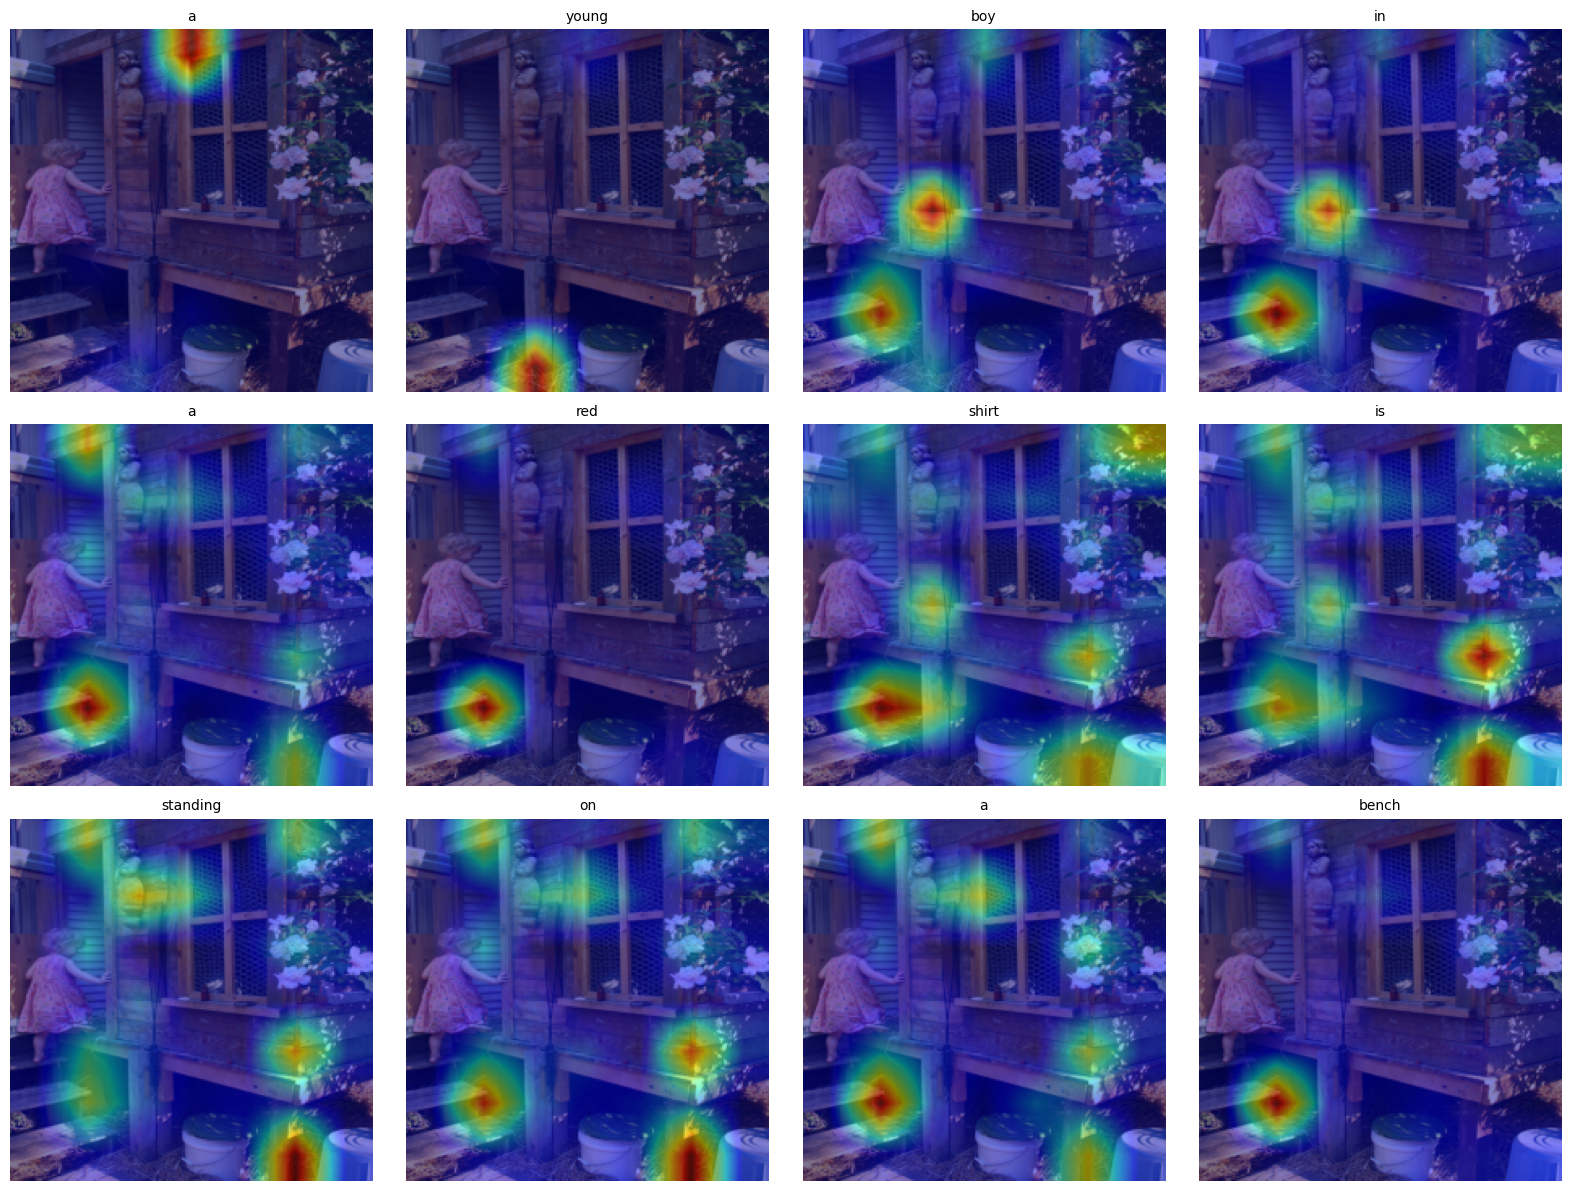

In [ ]:
import torchvision.transforms as transforms

def visualize_attention_grid(image, words, attention_weights, save_path=None):
    
    num_words = len(words)
    num_cols = 4 
    num_rows = (num_words + num_cols - 1) // num_cols
    
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
    else:
        image = np.array(image)
    
    if image.max() > 1:
        image = image / 255.0

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    axes = axes.flatten()

    for idx, (word, attn) in enumerate(zip(words, attention_weights)):
        ax = axes[idx]
        
        attn = attn.cpu().detach().numpy()
        attn = (attn - attn.min()) / (attn.max() - attn.min())
        attn = transforms.functional.resize(
            torch.tensor(attn).unsqueeze(0).unsqueeze(0), image.shape[:2]
        ).squeeze().numpy()
        
        ax.imshow(image)
        ax.imshow(attn, cmap='jet', alpha=0.5)
        ax.axis('off')
        ax.set_title(word, fontsize=10, color='black')

    for idx in range(len(words), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()




def generate_caption_with_attention(model, image, dataset, max_len=20):
    
    model.eval()
    with torch.no_grad():
        features = model.encoder(image.unsqueeze(0))

        batch_size, encoder_dim, H, W = features.shape
        features = features.view(batch_size, H * W, encoder_dim)

        caption = [dataset.vocab.stoi["<SOS>"]]
        h, c = model.decoder.init_hidden_state(1)
        attention_visualizations = []

        for _ in range(max_len):
            current_word = torch.tensor([caption[-1]]).to(image.device)
            embedding = model.decoder.embedding(current_word).unsqueeze(0)

            context, attention_weights = model.decoder.attention(features, h)

            lstm_input = torch.cat((embedding, context.unsqueeze(1)), dim=2).squeeze(0)

            h, c = model.decoder.lstm(lstm_input, (h, c))

            output = model.decoder.fc(h)
            predicted_word = output.argmax(1).item()

            num_features = attention_weights.size(1)
            side_length = int(num_features**0.5)
            if side_length**2 == num_features:
                attention_visualizations.append(attention_weights.view(side_length, side_length))
            else:
                raise ValueError(f"Invalid attention weights size: {attention_weights.size()}")

            if predicted_word == dataset.vocab.stoi["<EOS>"]:
                break

            caption.append(predicted_word)

        words = [dataset.vocab.itos[idx] for idx in caption]

        return words[1:-1], attention_visualizations



image, _ = dataset[0]
image = image.to(device)


words, attention_visualizations = generate_caption_with_attention(model, image, dataset)

visualize_attention_grid(image, words, attention_visualizations)



In [ ]:
def load_model(save_path, device):
    checkpoint = torch.load(save_path, map_location=device)
    
    embed_size = checkpoint['embed_size']
    attention_dim = checkpoint['attention_dim']
    encoder_dim = checkpoint['encoder_dim']
    decoder_dim = checkpoint['decoder_dim']
    state_dict = checkpoint['state_dict']
    
    model = ImageCaptioningModel(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim).to(device)
    
    model.load_state_dict(state_dict)
    print(f"Model loaded from {save_path}.")
    
    return model, checkpoint['epoch']

save_path = "image_captioning.pth"

loaded_model, last_epoch = load_model(save_path, device)

C:\Users\GamerBarny\AppData\Local\Temp\ipykernel_8984\1293296009.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path, map_location=device)


Model loaded from image_captioning.pth.


### 2.3. Evaluation on test set

Evaluate your trained model on the test set. Use the BLEU score as your metric: torchtext.data.metrics.bleu_score(...)

You may try **BLEU-1, 2** and **3**.

In [25]:
!pip install nltk


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 13.4 MB/s eta 0:00:00


In [ ]:
# I use NLTK because i could not install torchtext because of version problems
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

def generate_caption(model, image, vocab, max_length=20):
    
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        features = model.encoder(image)
        h, c = model.decoder.init_hidden_state(features)

        word = vocab.stoi["<SOS>"]
        generated_caption = []

        for _ in range(max_length):
            word_tensor = torch.tensor([word]).to(device)
            embedding = model.decoder.embedding(word_tensor)
            context, _ = model.decoder.attention(features, h)
            lstm_input = torch.cat((embedding, context), dim=1)
            h, c = model.decoder.lstm(lstm_input, (h, c))
            output = model.decoder.fc(h)
            word = output.argmax(1).item()

            if word == vocab.stoi["<EOS>"]:
                break
            generated_caption.append(vocab.itos[word])

        return generated_caption


def evaluate_bleu_scores(model, test_loader, vocab, max_length=20):
    
    references = [] 
    hypotheses = [] 
    smoothing = SmoothingFunction()

    model.eval()
    with torch.no_grad():
        for images, captions in tqdm(test_loader, desc="Evaluating BLEU scores"):
            for i in range(len(images)):
                ref_caption = captions[i].tolist()
                ref_caption = [vocab.itos[token] for token in ref_caption if token not in {vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]}]
                references.append([ref_caption])

                generated_caption = generate_caption(model, images[i], vocab, max_length=max_length)
                hypotheses.append(generated_caption)

    bleu_1 = sum(sentence_bleu(ref, hyp, weights=(1, 0, 0, 0), smoothing_function=smoothing.method1) for ref, hyp in zip(references, hypotheses)) / len(hypotheses)
    bleu_2 = sum(sentence_bleu(ref, hyp, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing.method1) for ref, hyp in zip(references, hypotheses)) / len(hypotheses)
    bleu_3 = sum(sentence_bleu(ref, hyp, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing.method1) for ref, hyp in zip(references, hypotheses)) / len(hypotheses)

    return bleu_1, bleu_2, bleu_3


bleu_1, bleu_2, bleu_3 = evaluate_bleu_scores(model, test_loader, dataset.vocab)
print(f"BLEU-1: {bleu_1:.4f}")
print(f"BLEU-2: {bleu_2:.4f}")
print(f"BLEU-3: {bleu_3:.4f}")


Evaluating BLEU scores:   0%|          | 0/253 [00:00<?, ?it/s]C:\Users\GamerBarny\AppData\Local\Temp\ipykernel_8984\579635606.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  captions = [torch.tensor(item[1], dtype=torch.long) for item in batch]
Evaluating BLEU scores: 100%|██████████| 253/253 [06:38<00:00,  1.57s/it]


BLEU-1: 0.3664
BLEU-2: 0.2025
BLEU-3: 0.1247


### 2.4. Load an existing Image Captioning model
Feel free to choose any pre-trained image captioning model. For simplicity, try choosing a model already trained on Flickr8k.

In [ ]:
!pip install transformers

In [ ]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer


gpt_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")



Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

### 2.5 Evaluate the chosen pre-trained captioning model on the test set
Use the same metrics **BLEU-1, 2** and **3**.

In [113]:
# Debugging
features = model.encoder(image.unsqueeze(0))
print(features.shape)

h, c = model.decoder.init_hidden_state(features)
print(h.shape, c.shape)

context, attention_weights = model.decoder.attention(features, h)
print(context.shape)
print(attention_weights.shape)



torch.Size([1, 196, 256])
torch.Size([1, 512]) torch.Size([1, 512])
torch.Size([1, 256])
torch.Size([1, 196])


In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt_model.to(device)

def generate_captions_batch(model, images, max_len=16):
    images = torch.clamp((images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(images.device)) +
                         torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(images.device), 0, 1)
    
    pixel_values = feature_extractor(images=images, return_tensors="pt", do_rescale=False).pixel_values.to(device)
    
    output_ids = model.generate(pixel_values, max_length=max_len, num_beams=4)
    captions = [tokenizer.decode(output_id, skip_special_tokens=True).split() for output_id in output_ids]
    return captions


def evaluate_model_bleu_pretrained(model, test_loader, parent_dataset, max_len=16):
    
    model.eval()
    references = []
    hypotheses = []

    with torch.no_grad():
        for images, captions in test_loader:
            generated_captions = generate_captions_batch(model, images, max_len)

            for i in range(len(images)):
                ground_truth = captions[i].tolist()
                references.append(
                    [[parent_dataset.vocab.itos[idx] for idx in ground_truth if idx not in {parent_dataset.vocab.stoi["<PAD>"]}]]
                )
                hypotheses.append(generated_captions[i])

    smoothing_function = SmoothingFunction().method1
    bleu_1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=smoothing_function)
    bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
    bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function)

    print(f"BLEU-1: {bleu_1:.4f}")
    print(f"BLEU-2: {bleu_2:.4f}")
    print(f"BLEU-3: {bleu_3:.4f}")

    return bleu_1, bleu_2, bleu_3

gpt_model_bleu_1, gpt_model_bleu_2, gpt_model_bleu_3 = evaluate_model_bleu_pretrained(
    model=gpt_model,
    test_loader=test_loader,
    parent_dataset=dataset,
    max_len=20
)



In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_blip_captions_batch(model, processor, images):
    
    inputs = processor(images=images, return_tensors="pt").to(device)
    output_ids = model.generate(**inputs, max_length=16, num_beams=4)
    captions = [processor.decode(output_id, skip_special_tokens=True).split() for output_id in output_ids]
    return captions

def evaluate_blip_bleu(model, processor, test_loader, parent_dataset, max_len=16):
    
    model.eval()
    references = []
    hypotheses = []

    with torch.no_grad():
        for images, captions in test_loader:
            images_pil = [Image.fromarray((image.permute(1, 2, 0).cpu().numpy() * 255).astype("uint8")) for image in images]

            generated_captions = generate_blip_captions_batch(model, processor, images_pil)

            for i in range(len(images)):
                ground_truth = captions[i].tolist()
                references.append(
                    [[parent_dataset.vocab.itos[idx] for idx in ground_truth if idx not in {parent_dataset.vocab.stoi["<PAD>"]}]]
                )
                hypotheses.append(generated_captions[i])

    smoothing_function = SmoothingFunction().method1
    bleu_1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=smoothing_function)
    bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
    bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function)

    print(f"BLEU-1: {bleu_1:.4f}")
    print(f"BLEU-2: {bleu_2:.4f}")
    print(f"BLEU-3: {bleu_3:.4f}")

    return bleu_1, bleu_2, bleu_3

blip_bleu_1, blip_bleu_2, blip_bleu_3 = evaluate_blip_bleu(
    model=model,
    processor=processor,
    test_loader=test_loader,
    parent_dataset=dataset,
    max_len=20
)


C:\Users\GamerBarny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\GamerBarny\.cache\huggingface\hub\models--Salesforce--blip-image-captioning-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


BLEU-1: 0.1435
BLEU-2: 0.0586
BLEU-3: 0.0270


# 3. COMPARISON
Compare the performance of the two models using **BLEU-1, 2** and **3**. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?

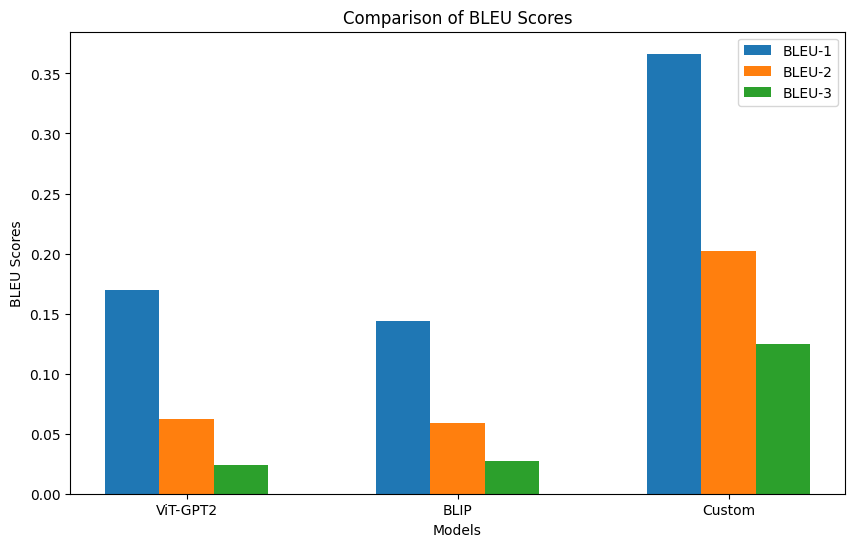

In [ ]:
gpt_model_bleu = {"BLEU-1": gpt_model_bleu_1, "BLEU-2": gpt_model_bleu_2, "BLEU-3": gpt_model_bleu_3}
blip_bleu = {"BLEU-1": blip_bleu_1, "BLEU-2": blip_bleu_2, "BLEU-3": blip_bleu_3}
custom_model_bleu = {"BLEU-1": bleu_1, "BLEU-2": bleu_1, "BLEU-3": bleu_1}

models = ["ViT-GPT2", "BLIP", "Custom"]
bleu_1_scores = [gpt_model_bleu["BLEU-1"], blip_bleu["BLEU-1"], custom_model_bleu["BLEU-1"]]
bleu_2_scores = [gpt_model_bleu["BLEU-2"], blip_bleu["BLEU-2"], custom_model_bleu["BLEU-2"]]
bleu_3_scores = [gpt_model_bleu["BLEU-3"], blip_bleu["BLEU-3"], custom_model_bleu["BLEU-3"]]

def plot_bleu_scores(models, bleu_1, bleu_2, bleu_3):
    x = np.arange(len(models))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width, bleu_1, width, label="BLEU-1")
    ax.bar(x, bleu_2, width, label="BLEU-2")
    ax.bar(x + width, bleu_3, width, label="BLEU-3")

    ax.set_xlabel("Models")
    ax.set_ylabel("BLEU Scores")
    ax.set_title("Comparison of BLEU Scores")
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    plt.show()

plot_bleu_scores(models, bleu_1_scores, bleu_2_scores, bleu_3_scores)



### Conclusion

The results clearly indicate that the **Custom Model** outperforms the pre-trained models (ViT-GPT2 and BLIP) across all BLEU metrics. However, it is essential to note that the custom model was trained on the Flickr8k dataset. Although this dataset was assumed to match the Flickr8k dataset that might have been used for training or evaluating the pre-trained models, slight differences between the datasets can lead to noticeable performance gaps. For instance:
- Variations in captions: The custom model might have been trained on a version of Flickr8k with different phrasing, length, or vocabulary compared to what the pre-trained models encountered during their training or evaluation.
- Annotation style: If the dataset annotations vary in detail or tone (e.g., formal vs. casual captions), this can significantly impact the BLEU scores.


# Improvements

## 1. Encoder Improvements
### Replace ResNet with Advanced Models
- **Current Limitation**: Using ResNet-50, which is effective but might not capture all hierarchical features.
- **Improvement**: Replace ResNet-50 with more recent architectures such as EfficientNet, ViT, or Swin Transformer for better feature extraction.

### Use Multi-Scale Features
- **Current Limitation**: The encoder outputs a fixed feature size, potentially losing finer details.
- **Improvement**: Experiment with multi-scale features to capture both coarse and fine-grained image details.

### Pretrained Models with Fine-Tuning
- **Current Limitation**: Fine-tuning is limited to specific blocks.
- **Improvement**: Use pre-trained models with task-specific fine-tuning across more layers (not just the last few).

---

## 2. Attention Module Improvements
### Multi-Head Attention
- **Current Limitation**: The attention mechanism is single-headed and linear.
- **Improvement**: Replace with multi-head self-attention (inspired by transformers) to learn diverse attention patterns.

### Spatial Attention
- **Current Limitation**: Attention works on flattened feature maps.
- **Improvement**: Incorporate positional encodings or spatial attention to give explicit spatial context to the model.

---

## 3. Decoder Improvements
### Replace LSTM with Transformers
- **Current Limitation**: LSTM processes sequence data sequentially, which is slower.
- **Improvement**: Replace LSTM with transformer decoders for parallel processing and improved performance on long captions.

### Pretrained Language Models
- **Current Limitation**: Decoder embeddings are learned from scratch.
- **Improvement**: Integrate pretrained language models (e.g., GPT or BERT) for better language generation.

---

## 4. Data Augmentation
### Image Augmentation
- **Current Limitation**: Limited augmentation techniques.
- **Improvement**: Use advanced augmentation techniques like CutMix, MixUp, or random erasing to make the model robust.

### Caption Augmentation
- **Current Limitation**: The same captions are used for training repeatedly.
- **Improvement**: Use paraphrasing or synonym replacement techniques to diversify captions.

---

## 5. Training and Regularization
### Mixed Precision Training
- **Current Limitation**: Training uses full precision, which is memory-intensive.
- **Improvement**: Implement mixed precision training (e.g., using NVIDIA AMP) for faster training and reduced memory usage.

---

## 6. Loss Function
### Combine CrossEntropyLoss with Metric-based Loss
- **Current Limitation**: The model is optimized for CrossEntropyLoss only.
- **Improvement**: Combine CrossEntropyLoss with metric-based losses (e.g., CIDEr, BLEU) to directly optimize caption quality.
